PyTorch version: 2.8.0+rocm7.1.0.git7a520360
Torch device: cuda
Found CUDA device: cuda:0 - AMD Radeon AI PRO R9700
Found CUDA device: cuda:1 - AMD Radeon AI PRO R9700
helper_functions.py already exists, skipping download


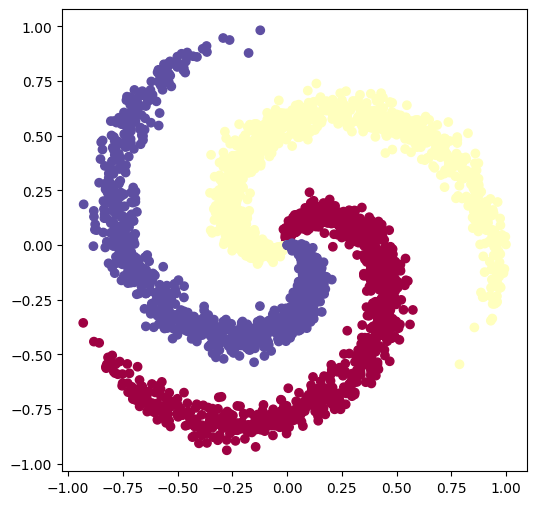

Epoch: 0, Loss: 1.13442, Acc: 33.92%, Test Loss: 1.14833, Test Acc: 31.00%
Epoch: 1000, Loss: 0.18740, Acc: 94.33%, Test Loss: 0.18603, Test Acc: 94.33%
Epoch: 2000, Loss: 0.06660, Acc: 99.33%, Test Loss: 0.06155, Test Acc: 99.00%
Epoch: 3000, Loss: 0.04143, Acc: 99.54%, Test Loss: 0.03732, Test Acc: 99.33%
Epoch: 4000, Loss: 0.03098, Acc: 99.54%, Test Loss: 0.02758, Test Acc: 99.67%
Epoch: 5000, Loss: 0.02479, Acc: 99.71%, Test Loss: 0.02170, Test Acc: 99.67%
Epoch: 6000, Loss: 0.02087, Acc: 99.75%, Test Loss: 0.01798, Test Acc: 99.67%
Epoch: 7000, Loss: 0.01816, Acc: 99.83%, Test Loss: 0.01545, Test Acc: 99.67%
Epoch: 8000, Loss: 0.01623, Acc: 99.83%, Test Loss: 0.01377, Test Acc: 99.67%
Epoch: 9000, Loss: 0.01475, Acc: 99.88%, Test Loss: 0.01264, Test Acc: 99.67%
Training finished, took 39.65s


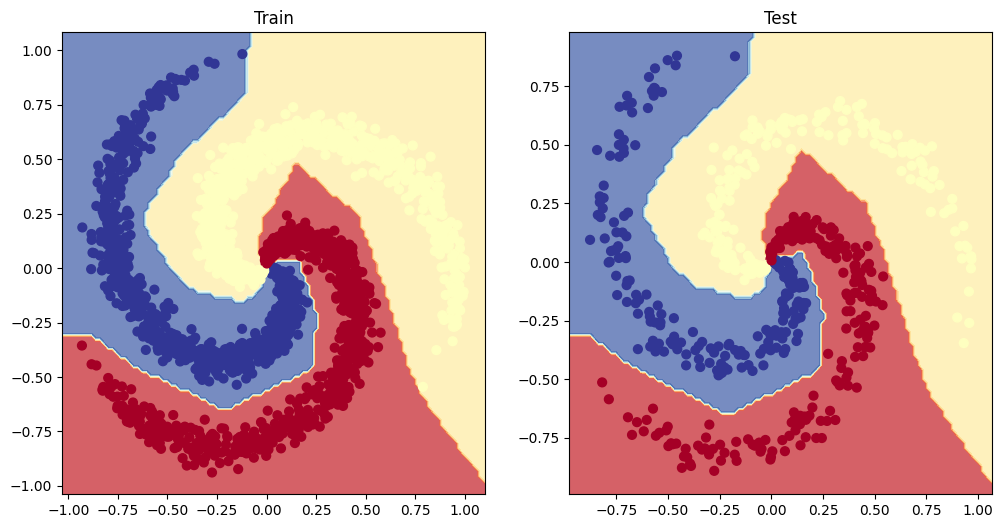

In [4]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import requests
from pathlib import Path
import numpy as np
import time

NUM_CLASSES = 3
NUM_FEATURES = 2
NUM_SAMPLES = 1000
HIDDEN_FEATURES = 16
RANDOM_SEED = 42
EPOCHS = 5000
LR = 0.1
TRAIN_TEST_SPLIT_RATIO=0.2

print(f"PyTorch version: {torch.__version__}")

device = torch.accelerator.current_accelerator() if torch.accelerator.is_available() else torch.device("cpu")
print(f"Torch device: {device}")
if torch.cuda.is_available():
    for device_id in range(torch.cuda.device_count()):
        print(f"Found CUDA device: cuda:{device_id} - {torch.cuda.get_device_name(device_id)}")

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

def accuracy_fn(y_acctual, y_pred):
    correct = torch.eq(y_acctual, y_pred).sum().item();
    acc = (correct / len(y_pred)) * 100
    return acc

np.random.seed(42)
X = np.zeros((NUM_SAMPLES*NUM_CLASSES,NUM_FEATURES)) # data matrix (each row = single example)
y = np.zeros(NUM_SAMPLES*NUM_CLASSES, dtype='uint8') # class labels
for j in range(NUM_CLASSES):
    ix = range(NUM_SAMPLES*j,NUM_SAMPLES*(j+1))
    r = np.linspace(0.0,1,NUM_SAMPLES) # radius
    t = np.linspace(j*4,(j+1)*4,NUM_SAMPLES) + np.random.randn(NUM_SAMPLES)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.long)

# lets visualize the data
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=TRAIN_TEST_SPLIT_RATIO,
                                                    random_state=RANDOM_SEED)

# Move data to device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

torch.manual_seed(seed=42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

model_ =  nn.Sequential(
    nn.Linear(in_features=NUM_FEATURES, out_features=HIDDEN_FEATURES),
    nn.ReLU(),
    nn.Linear(in_features=HIDDEN_FEATURES, out_features=HIDDEN_FEATURES),
    nn.ReLU(),
    nn.Linear(in_features=HIDDEN_FEATURES, out_features=NUM_CLASSES),
).to(device)

model = nn.DataParallel(model_)

# Setup loss function
loss_fn = nn.CrossEntropyLoss()

# Setup optimiser function
optimiser = torch.optim.SGD(params=model.parameters(), lr=LR)

# Time the training
training_start = time.time()

for epoch in range(EPOCHS):
    #Set training
    model.train()

    #Forward pass
    y_logits = model(X_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    #Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_acctual=y_train, y_pred=y_pred)

    # Optimizer zero grad
    optimiser.zero_grad()

    # Loss backwards
    loss.backward()

    # Optimiser step
    optimiser.step()

    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(1)

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_acctual=y_test, y_pred=test_preds)

    # Print progress
    if epoch % (EPOCHS/10) == 0:
        print(f"Epoch: {epoch}, Loss: {loss:.5f}, Acc: {acc:.2f}%, Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

print('Training finished, took {:.2f}s'.format(time.time() - training_start))

# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_, X_test, y_test)
plt.show()